<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11/S11_Assignment(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   customNet.py    execute.py    resNet.py
AlbTrainTransforms.py  cyclicLR.py     Gradcam.py    rohan_library.py
albumentations.py      DataLoaders.py  LR_Finder.py
all.py		       displayData.py  __pycache__


In [3]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [3]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf
import cyclicLR as clr
import customNet

  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [4]:
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [5]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [6]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [7]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

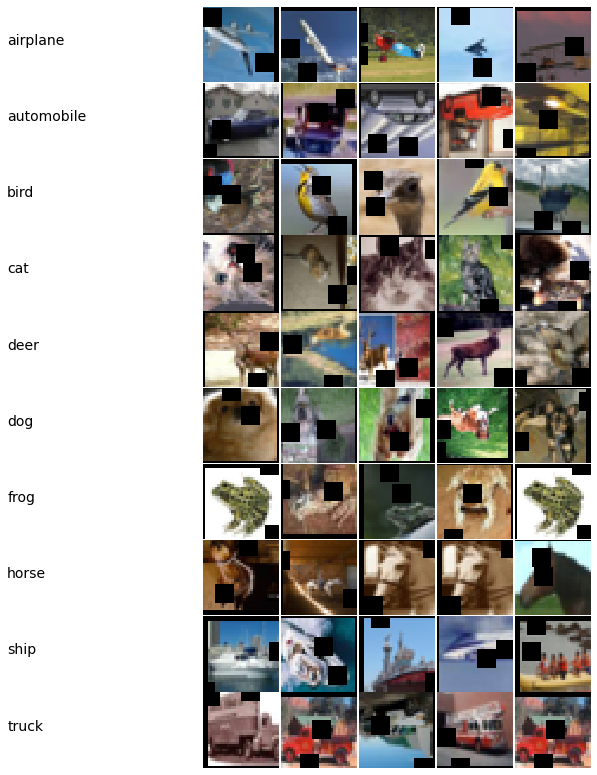

In [8]:
display.class_images(trainLoader)


**CustomNet**

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = customNet.main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-1

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


**LR Finder**

In [11]:
# criterion = execute.cross_entropy_loss()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


The loss has diverged, Stopping Early!


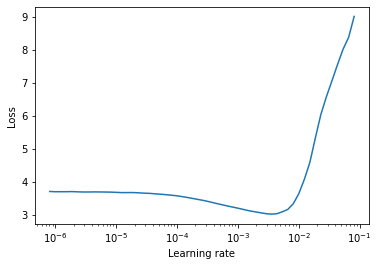

In [12]:
lr_finder.plot()

In [13]:
lr_finder.reset()

**Cyclic Learning Rate Range Test**

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


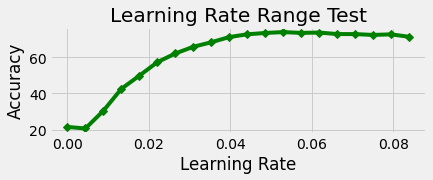

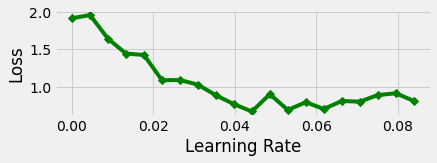

In [14]:
clr.lr_rangetest(device, model, trainLoader, criterion, 0.0001, 0.001, 20)

**Cyclic LR Plot**

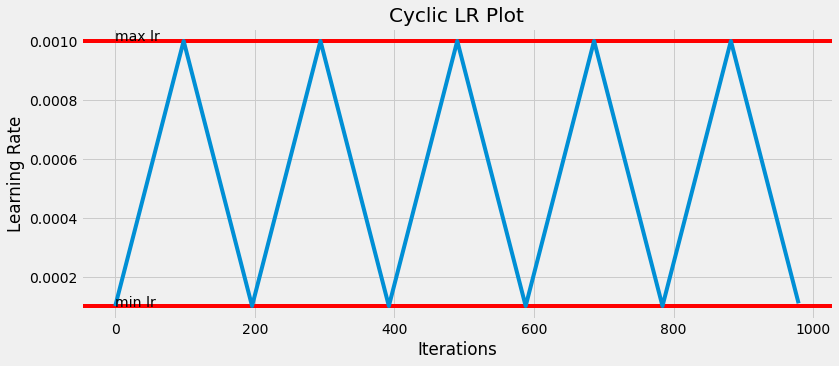

In [15]:
clr1 = clr.CyclicLR(0.001, 0.0001, len(trainLoader), len(trainLoader)*10)
clr1.cyclic_lr(plotGraph=True)

**Modelling**

In [18]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = customNet.main11().to(device)
EPOCHS = 24

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, weight_decay = 1e-2, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.02, total_steps=2400, epochs = 24, steps_per_epoch=len(trainLoader),
                                                pct_start=5/EPOCHS, anneal_strategy='linear', cycle_momentum=True, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=24, final_div_factor=1)



model1 = execute.Test_Train(model, device, optimizer, scheduler, criterion)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda=1e-5)
  scheduler.step()
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1


/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)
Loss=2.2618510723114014 Batch_id=97 Accuracy=33.98: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.5165).  Saving model ...

Test set: Average loss: 1.5165, Accuracy: 4874/10000 (48.74%)

Learning Rate = 0.00464 for EPOCH 2
EPOCH:  2


Loss=1.9992587566375732 Batch_id=97 Accuracy=48.31: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.5165 --> 1.2517).  Saving model ...

Test set: Average loss: 1.2517, Accuracy: 5476/10000 (54.76%)

Learning Rate = 0.00844 for EPOCH 3
EPOCH:  3


Loss=1.8326342105865479 Batch_id=97 Accuracy=55.52: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.2517 --> 1.0726).  Saving model ...

Test set: Average loss: 1.0726, Accuracy: 6097/10000 (60.97%)

Learning Rate = 0.01224 for EPOCH 4
EPOCH:  4


Loss=1.5213525295257568 Batch_id=97 Accuracy=61.42: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.0726 --> 0.9913).  Saving model ...

Test set: Average loss: 0.9913, Accuracy: 6591/10000 (65.91%)

Learning Rate = 0.01604 for EPOCH 5
EPOCH:  5


Loss=1.5807424783706665 Batch_id=97 Accuracy=65.40: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1513, Accuracy: 6087/10000 (60.87%)

Learning Rate = 0.01985 for EPOCH 6
EPOCH:  6


Loss=1.126967430114746 Batch_id=97 Accuracy=69.90: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.9913 --> 0.9504).  Saving model ...

Test set: Average loss: 0.9504, Accuracy: 6890/10000 (68.90%)

Learning Rate = 0.01904 for EPOCH 7
EPOCH:  7


Loss=0.9675170183181763 Batch_id=97 Accuracy=73.86: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.9504 --> 0.8310).  Saving model ...

Test set: Average loss: 0.8310, Accuracy: 7514/10000 (75.14%)

Learning Rate = 0.01804 for EPOCH 8
EPOCH:  8


Loss=0.8876039981842041 Batch_id=97 Accuracy=76.21: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.8310 --> 0.6059).  Saving model ...

Test set: Average loss: 0.6059, Accuracy: 7944/10000 (79.44%)

Learning Rate = 0.01704 for EPOCH 9
EPOCH:  9


Loss=0.7176492214202881 Batch_id=97 Accuracy=79.04: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6342, Accuracy: 7786/10000 (77.86%)

Learning Rate = 0.01605 for EPOCH 10
EPOCH:  10


Loss=0.6961524486541748 Batch_id=97 Accuracy=80.63: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.6059 --> 0.5027).  Saving model ...

Test set: Average loss: 0.5027, Accuracy: 7959/10000 (79.59%)

Learning Rate = 0.01505 for EPOCH 11
EPOCH:  11


Loss=0.7238500714302063 Batch_id=97 Accuracy=81.96: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5335, Accuracy: 8068/10000 (80.68%)

Learning Rate = 0.01405 for EPOCH 12
EPOCH:  12


Loss=0.6675507426261902 Batch_id=97 Accuracy=83.35: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7138, Accuracy: 8110/10000 (81.10%)

Learning Rate = 0.01305 for EPOCH 13
EPOCH:  13


Loss=0.6321904063224792 Batch_id=97 Accuracy=84.21: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5110, Accuracy: 8175/10000 (81.75%)

Learning Rate = 0.01205 for EPOCH 14
EPOCH:  14


Loss=0.6340317726135254 Batch_id=97 Accuracy=85.11: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5027 --> 0.4298).  Saving model ...

Test set: Average loss: 0.4298, Accuracy: 8212/10000 (82.12%)

Learning Rate = 0.01105 for EPOCH 15
EPOCH:  15


Loss=0.5439099073410034 Batch_id=97 Accuracy=85.79: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4382, Accuracy: 8514/10000 (85.14%)

Learning Rate = 0.01005 for EPOCH 16
EPOCH:  16


Loss=0.5513054728507996 Batch_id=97 Accuracy=86.58: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4806, Accuracy: 8509/10000 (85.09%)

Learning Rate = 0.00905 for EPOCH 17
EPOCH:  17


Loss=0.5303357243537903 Batch_id=97 Accuracy=86.88: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.4298 --> 0.4045).  Saving model ...

Test set: Average loss: 0.4045, Accuracy: 8746/10000 (87.46%)

Learning Rate = 0.00806 for EPOCH 18
EPOCH:  18


Loss=0.45868194103240967 Batch_id=97 Accuracy=87.61: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4076, Accuracy: 8703/10000 (87.03%)

Learning Rate = 0.00706 for EPOCH 19
EPOCH:  19


Loss=0.40644633769989014 Batch_id=97 Accuracy=88.45: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.4045 --> 0.3907).  Saving model ...

Test set: Average loss: 0.3907, Accuracy: 8689/10000 (86.89%)

Learning Rate = 0.00606 for EPOCH 20
EPOCH:  20


Loss=0.42735910415649414 Batch_id=97 Accuracy=89.22: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.3907 --> 0.3266).  Saving model ...

Test set: Average loss: 0.3266, Accuracy: 8800/10000 (88.00%)

Learning Rate = 0.00506 for EPOCH 21
EPOCH:  21


Loss=0.3793928623199463 Batch_id=97 Accuracy=89.63: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4004, Accuracy: 8791/10000 (87.91%)

Learning Rate = 0.00406 for EPOCH 22
EPOCH:  22


Loss=0.36372095346450806 Batch_id=97 Accuracy=90.51: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4961, Accuracy: 8761/10000 (87.61%)

Learning Rate = 0.00306 for EPOCH 23
EPOCH:  23


Loss=0.33938589692115784 Batch_id=97 Accuracy=91.99: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.3266 --> 0.2542).  Saving model ...

Test set: Average loss: 0.2542, Accuracy: 9038/10000 (90.38%)

Learning Rate = 0.00206 for EPOCH 24
EPOCH:  24


Loss=0.2987825274467468 Batch_id=97 Accuracy=92.88: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 0.2875, Accuracy: 9113/10000 (91.13%)

Learning Rate = 0.00107 for EPOCH 25


**Plot Train & Test Curves**

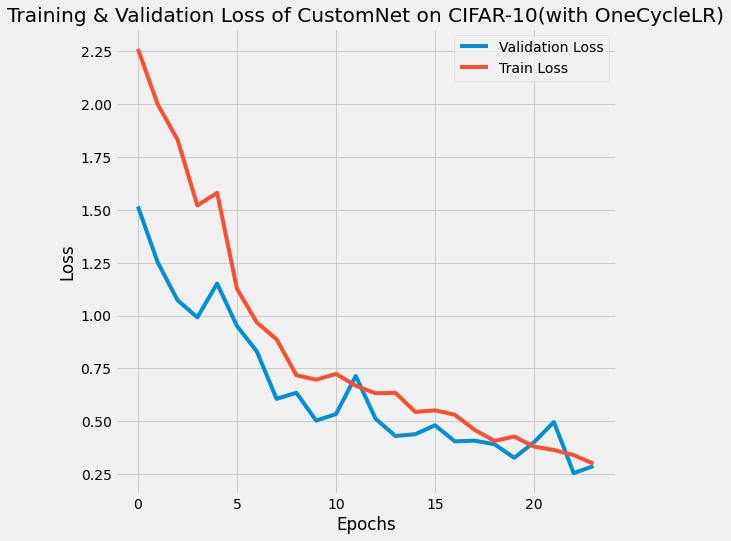

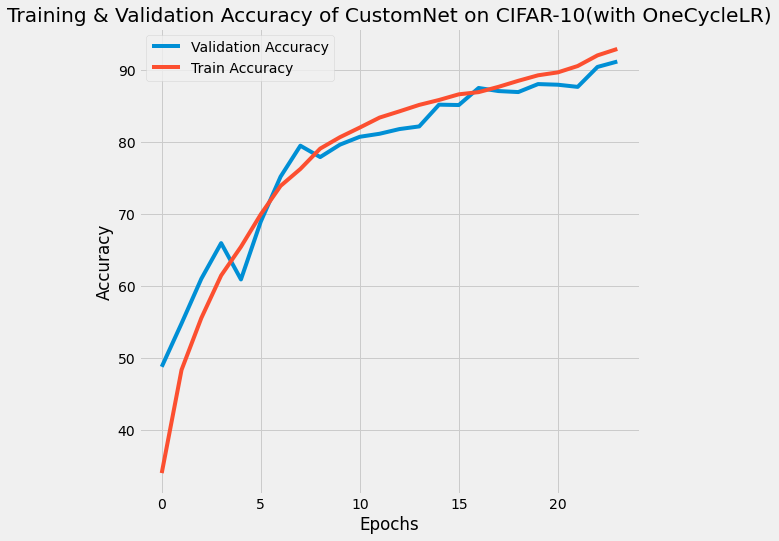

In [19]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of CustomNet on CIFAR-10(with OneCycleLR)', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of CustomNet on CIFAR-10(with OneCycleLR)')


**CLR Plot**

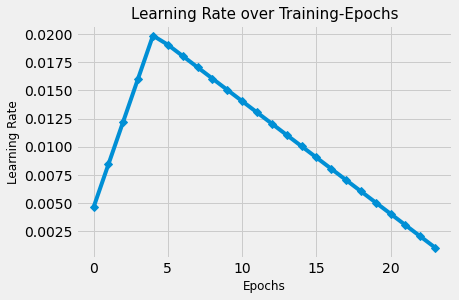

In [20]:
with plt.style.context('fivethirtyeight'):
  plt.plot(learningRates, '-D')
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Learning Rate', fontsize=12)
  plt.title('Learning Rate over Training-Epochs',fontsize=15)

**Misclassified Images**

<Figure size 936x936 with 0 Axes>

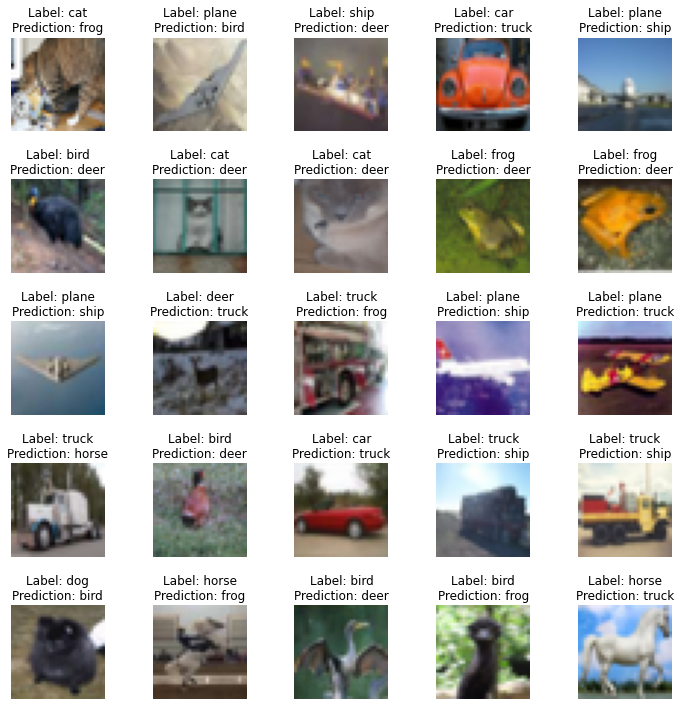

In [21]:
display.misclassified_ones(model, testLoader, incorrectSamples,'MisclassfiedOnes.png')

#GradCam Implementation

**GradCam Input Data**

In [22]:
images = [x['image'] for x in incorrectSamples[10:35]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:35]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:35]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


**GradCam Core** 

In [ ]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM FOR SET[...]')
gradcam_output, probs, predicted_classes = gdc.GRADCAM(images, device, target_classes, model, target_layers) 
gdc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
